# Adaptive Intelligence COM3240

#### Script that returns the learnign curve for each trial

In [19]:
import numpy as np
import scipy.spatial.distance as dist

def Start(N, M):
    return np.array([np.random.randint(N), np.random.randint(M)])   #random start

def homing_nn(n_trials, learning_rate, eps, gamma, max_steps=50, count_min_steps=False, count_actions=False):

    # Solving homing task with on-policy TD (SARSA)


    ## Definition of the environment
    N = 3                               #height of the gridworld ---> number of rows
    M = 4                              #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    states_matrix = np.eye(N_states)
    N_actions = 4                                           #number of possible actions in each state: 1->N 2->E 3->S 4->W
    action_row_change = np.array([-1, 0, +1, 0])               #number of cell shifted in vertical as a function of the action
    action_col_change = np.array([0, +1, 0, -1])               #number of cell shifted in horizontal as a function of the action
    End = np.array([1, 1])                                  #terminal state--->reward
    s_end = np.ravel_multi_index(End, dims = (N, M), order = 'F')  #terminal state. Conversion in single index

    ## Parameters of the model
    #gamma = 0.9                        #discounting factor
    #learning_rate = 0.5                #constant step-size parameter (learning rate)
    #eps = 0.0                          #epsilon-greedy SARSA

    ## Rewards
    R = 10                              #only when the robot reaches the charger, sited in End state

    ## Variables
    weights = np.random.rand(N_actions, N_states)
    learning_curve = np.zeros((1 + count_min_steps + count_actions, n_trials))

    ## SARSA

    # Start trials
    for trial in range(n_trials):

        # Initialization
        Start_mat = Start(N, M)
        s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')      #conversion in single index
        
        #Make sure the robot doesn't start on the goal
        while s_start == s_end:
            Start_mat = Start(N, M)
            s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')
        state = Start_mat                                                   #set current state
        s_index = s_start      
        step = 0
        
        #Manhattan Distance between start and end
        if count_min_steps:
            min_steps = dist.cityblock(Start_mat, End)
        
        # Start steps
        while s_index != s_end and step <= max_steps:

            step += 1
            learning_curve[0, trial]= step
            if count_min_steps:
                learning_curve[1, trial]= min_steps

            input_vector = states_matrix[:, s_index].reshape(N_states, 1)         #convert the state into an input vector

            #compute Qvalues. Qvalue = logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig

            #eps-greedy policy implementation
            greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
            if greedy:
                action = np.argmax(Q)                           #pick best action
            else:
                action = np.random.randint(N_actions)           #pick random action
            if count_actions:
                learning_curve[-1, trial]= action

            state_new = np.array([0, 0])
            #move into a new state
            state_new[0]= state[0] + action_row_change[action]
            state_new[1]= state[1] + action_col_change[action]

            #initialise reward
            r = 0
            
            #put the robot back in grid if it goes out.
            lt_x = state_new[0] < 0
            if lt_x:
                state_new[0]= 0
            gt_x = state_new[0] >= N
            if gt_x:
                state_new[0]= N-1
            lt_y = state_new[1] < 0
            if lt_y:
                state_new[1]= 0
            gt_y = state_new[1] >= M
            if gt_y:
                state_new[1]= M-1
            #give a negative reward
            if lt_x or gt_x or lt_y or gt_y:
                r = -1
            
            s_index_new = np.ravel_multi_index(state_new, dims = (N, M), order = 'F')  #conversion in a single index

            #if is not the first step
            if step > 1: 
                #update Qvalues
                weights += learning_rate * (r_old + gamma * Q[action] - Q_old) * output_old.dot(input_old.T)

            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions, 1))
            output[action]= 1

            #update variables
            input_old = input_vector
            output_old = output
            Q_old = Q[action]
            r_old = r

            state[0]= state_new[0]
            state[1]= state_new[1]
            s_index = s_index_new

            ## check if state is terminal and update the weights consequently
            if s_index == s_end:
                weights += learning_rate * (R - Q_old) * output_old.dot(input_old.T)
                pass


    return learning_curve


#### Call the function homing_nn


(2, 100)
[[  1.  33.   3.   1.   1.   1.   1.   2.   2.   5.   5.   3.   2.   2.
    2.   2.   2.   2.   3.   4.   2.   2.   2.   3.   3.   1.   1.   1.
    1.   2.   1.   2.   1.   2.   1.   3.   2.   2.   2.   3.   2.   2.
    4.   3.   2.   3.   1.   1.   4.   3.   1.   2.   3.   2.   1.   2.
    3.   1.   1.   1.   2.   1.   2.   1.   3.   3.   1.   1.   4.   3.
    2.   1.   2.   2.   4.   1.   1.   2.   2.   2.   4.   2.   2.   1.
    1.   2.   1.   2.   3.   2.   1.   1.   2.   2.   3.   3.   1.   2.
    1.   2.]
 [  1.   3.   1.   1.   1.   1.   1.   2.   2.   3.   3.   3.   2.   2.
    2.   2.   2.   2.   3.   2.   2.   2.   2.   3.   3.   1.   1.   1.
    1.   2.   1.   2.   1.   2.   1.   3.   2.   2.   2.   3.   2.   2.
    2.   3.   2.   3.   1.   1.   2.   3.   1.   2.   3.   2.   1.   2.
    3.   1.   1.   1.   2.   1.   2.   1.   3.   3.   1.   1.   2.   3.
    2.   1.   2.   2.   2.   1.   1.   2.   2.   2.   2.   2.   2.   1.
    1.   2.   1.   2.   3.   2.   1.   1. 

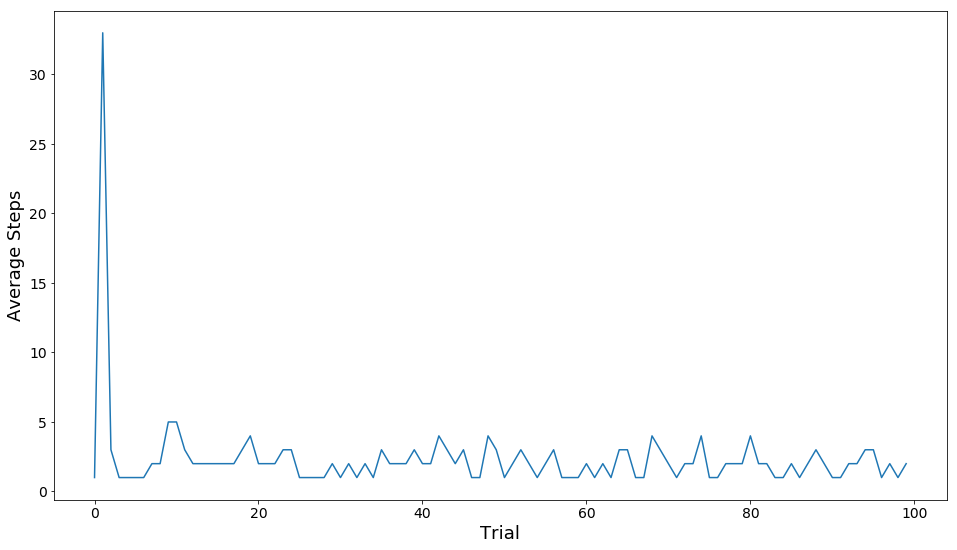

In [20]:
#We will call this procedure one run of the algorithm.
n_trials = 100
learning_rate=0.5                #constant step-size parameter (learning rate)
eps=0.0                          #epsilon-greedy SARSA
gamma=0.9                        #discounting factor

import matplotlib.pyplot as plt
l_curve=homing_nn(n_trials,learning_rate,eps,gamma, count_min_steps=True)
print(l_curve.shape)
print(l_curve)
fontsize=18
plt.figure(figsize=(16, 9))
plt.plot(l_curve[0].T)
plt.xlabel('Trial',fontsize=fontsize)
plt.ylabel('Average Steps',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

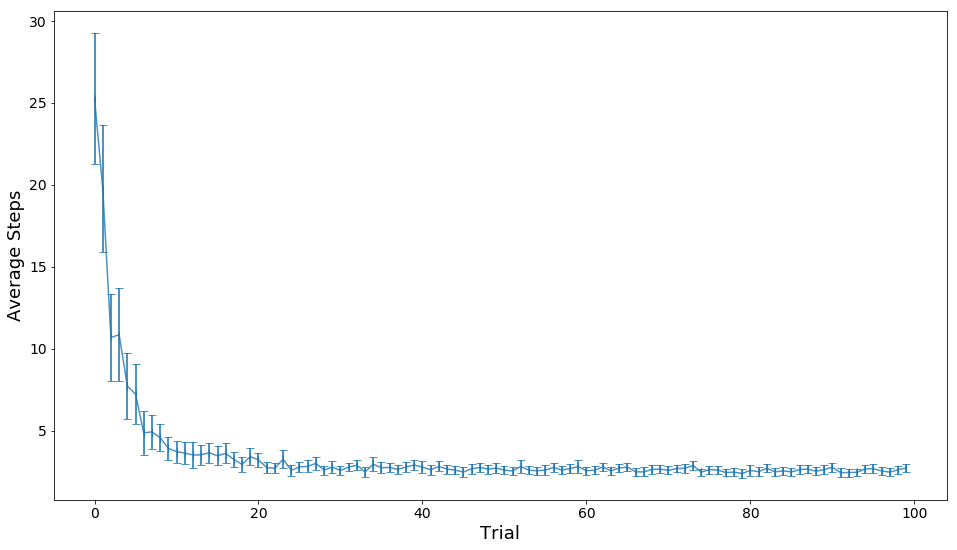

In [21]:
#produce a curve that is the average of the learning curves of the individual runs.
def manyruns(n_trials,learning_rate,eps,gamma):
    runs=100
    total_steps=np.zeros((runs,n_trials))
    for j in range(runs):
        total_steps[j,:]=homing_nn(n_trials,learning_rate,eps,gamma)
    plt.figure(figsize=(16, 9))
    means=np.mean(total_steps, axis=0)
    errors=2*np.std(total_steps, axis=0)/np.sqrt(runs)
    plt.errorbar(np.arange(n_trials), means, errors, 0, elinewidth=2, capsize=4, alpha=0.8)
    plt.xlabel('Trial',fontsize=fontsize)
    plt.ylabel('Average Steps',fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
manyruns(n_trials,learning_rate,eps,gamma)

In [31]:
""" Minimise total difference between the actual number of steps and the total number of steps subject to learning_rate, eps,
    and gamma all between 0 and 1 inclusive."""
from scipy.optimize import minimize
from tabulate import tabulate
def to_optimise(aeg):
    lc = homing_nn(n_trials,
                   aeg[0],
                   aeg[1],
                   aeg[2],
                   count_min_steps=True)
    equal = sum(i!=j for i,j in lc.T)
    return equal
cons = ({'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]},
        {'type': 'ineq', 'fun': lambda x:  1-x[0]},
        {'type': 'ineq', 'fun': lambda x:  1-x[1]},
        {'type': 'ineq', 'fun': lambda x:  1-x[2]})
param_minima=[]
while len(param_minima) < 10:
    res = minimize(to_optimise, np.random.rand(3), method='COBYLA', constraints=cons, tol=1e-6)
    if res.fun <=10:
        param_minima += [np.append(res.x,res.fun)]

In [32]:
param_minima = np.abs(np.round(np.array(param_minima),6))
print(tabulate(param_minima, headers=["$\\alpha$", "$\epsilon$", "$\gamma$", "$g$"],floatfmt=".6f", tablefmt="latex_raw"))

\begin{tabular}{rrrr}
\hline
   $\alpha$ &   $\epsilon$ &   $\gamma$ &      $g$ \\
\hline
   0.956711 &     0.000000 &   0.738994 & 7.000000 \\
   0.958413 &     0.000000 &   0.612594 & 8.000000 \\
   1.000000 &     0.013321 &   0.746125 & 7.000000 \\
   0.999999 &     0.000000 &   0.657053 & 9.000000 \\
   0.979989 &     0.000000 &   0.806225 & 6.000000 \\
   0.999999 &     0.000000 &   0.630597 & 8.000000 \\
   0.925786 &     0.000148 &   0.549201 & 9.000000 \\
   1.000000 &     0.000000 &   0.528068 & 9.000000 \\
   1.000000 &     0.013471 &   0.674773 & 8.000000 \\
   1.000000 &     0.000000 &   0.437343 & 9.000000 \\
\hline
\end{tabular}


\overline{\alpha} &= 0.9820897 \pm 0.015879\\
\overline{\epsilon} &= 0.002694 \pm 0.003384\\
\overline{\gamma} &= 0.6380973 \pm 0.067183\\


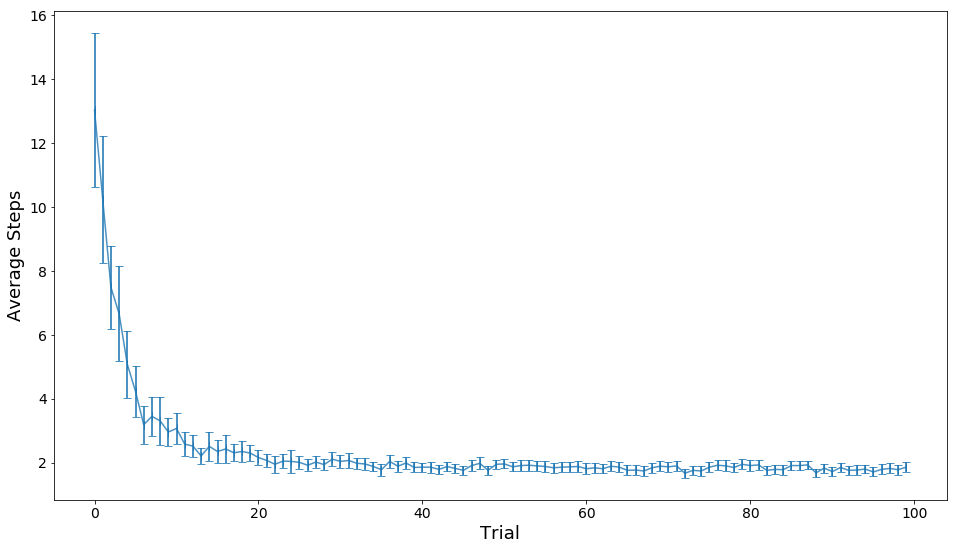

In [33]:
param_means = np.mean(param_minima.T[:3], axis=1)
param_sems =  np.round(2*np.std(param_minima.T[:3], axis=1)/np.sqrt(10),6)
param_names = ["\overline{\\alpha}", "\overline{\epsilon}", "\overline{\gamma}"]
for i in range(3):
    print(param_names[i], '&=', str(param_means[i]),'\pm',str(param_sems[i])+"\\\\")
manyruns(n_trials, *tuple(param_means))

In [35]:
l_curve=homing_nn(n_trials,*tuple(param_means), count_actions=True)
print(l_curve.shape)
print(l_curve[0])

(2, 100)
[  1.  12.   4.   3.   3.   1.   2.   9.   6.   3.   5.   1.   4.   2.   2.
   2.   1.   1.   7.   1.   2.   1.   3.   2.   1.   2.   2.   2.   1.   1.
   4.   2.   2.   1.   1.   2.   1.   2.   1.   2.   1.   1.   1.   2.   1.
   1.   3.   1.   3.   1.   2.   2.   2.   1.   2.   1.   1.   1.   1.   2.
   2.   2.   2.   2.   3.   1.   1.   1.   3.   2.   3.   3.   2.   3.   2.
   1.   2.   1.   1.   2.   1.   1.   3.   3.   2.   3.   2.   2.   2.   3.
   1.   2.   3.   1.   3.   1.   3.   2.   1.   2.]
